<a href="https://colab.research.google.com/github/kimimumemo/Computational-Finance-/blob/main/Predicting%20Put%20Option%20with%20Monte%20Carlo%2C%20Binomal%20CRR%2C%20and%20bBTT%20Method.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import random
import math
import sys
import statistics
import scipy
import matplotlib.pyplot as plt
from scipy.stats import norm

In [ ]:
# parameter
s_0 = 100 # nilai awal
X = 90 # strike price
r = 0.06 # tingkat suku bunga bebas resiko
sigma = 0.15 # volatilitas
T = 1 # waktu jatuh tempo
N = 250 # banyak selang waktu

In [ ]:
delta_t = T/N
sqrt_delta_t = math.sqrt(delta_t)
sum_tn = T*N

In [ ]:
mean, std = 0, 1 # mean and standar deviasi

### Metode Monte Carlo

In [ ]:
M = 10**5 # banyak iterasi yang dilakukan untuk melihat harga pergerakan saham pada 1 periode

In [ ]:
s_zeros_mc = np.zeros((M,N+1))
for i in range(0,M):
  s_zeros_mc[i,0] = s_0

In [ ]:
for i in range(0,M):
  for j in range(1,N+1):
    s_zeros_mc[i,j] = np.exp(((r-(sigma**2))/2)*delta_t+sigma*np.random.normal(mean, std,1)*sqrt_delta_t)*s_zeros_mc[i,j-1]

In [ ]:
s_zeros_mc

array([[100.        ,  99.02303006,  97.78719091, ..., 102.14386113,
        102.97717023, 101.66197773],
       [100.        , 100.27184542, 101.42416582, ..., 106.3764253 ,
        105.92742132, 105.54419869],
       [100.        ,  99.73465867, 100.1020994 , ...,  85.11543051,
         85.46992984,  86.1844663 ],
       ...,
       [100.        , 100.06899239,  99.42304082, ..., 101.00251331,
        102.03423243, 101.24125754],
       [100.        ,  99.77988323,  98.29045208, ...,  95.84639097,
         97.12390587,  96.96057692],
       [100.        , 100.07500851, 101.83968848, ..., 116.81433213,
        117.74063934, 119.01453944]])

In [ ]:
payoff_amerika_mc = []

for i in range(0,M):
  fill_payoff = np.exp(-r*T)*np.maximum(X-s_zeros_mc[i,N],0)
  payoff_amerika_mc.append(fill_payoff)
ekspektasi_payoff = 1/M*(sum(payoff_amerika_mc))

In [ ]:
np.round(ekspektasi_payoff, decimals=2)

1.37

### Metode Binomial

In [ ]:
u = np.exp(sigma*math.sqrt(delta_t))
d = np.exp(-1*sigma*math.sqrt(delta_t))
p = (np.exp(r*delta_t)-d)/(u-d)

In [ ]:
s_zeros_binom = np.zeros((N+1,N+1))

In [ ]:
# mengalikan S0 dengan u dan d sesuai dengan urutan

for i in range(0,N+1):
  for j in range(0,N+1):
    if i >= j:
      s_zeros_binom[i,j] += s_0*u**(i-j)*d**(j)

In [ ]:
s_zeros_binom

array([[ 100.        ,    0.        ,    0.        , ...,    0.        ,
           0.        ,    0.        ],
       [ 100.95319756,   99.05580251,    0.        , ...,    0.        ,
           0.        ,    0.        ],
       [ 101.91548098,  100.        ,   98.1205201 , ...,    0.        ,
           0.        ,    0.        ],
       ...,
       [1051.42825861, 1031.66687583, 1012.27690426, ...,    9.51087239,
           0.        ,    0.        ],
       [1061.45044714, 1041.50069934, 1021.92590303, ...,    9.6015298 ,
           9.42107098,    0.        ],
       [1071.56816693, 1051.42825861, 1031.66687583, ...,    9.69305135,
           9.51087239,    9.33211746]])

In [ ]:
f_zeros_binom = np.zeros((N+1,N+1))

In [ ]:
# mencari harga opsi pada langkah ke-T

for j in range(0,N+1):
  f_zeros_binom[N,j] += max(X-s_zeros_binom[N,j],0)

In [ ]:
for i in range(N-1,0,-1):
  for j in range(0,N):
    if i >= j:
      f_zeros_binom[i,j] += max(X-s_zeros_binom[i,j],np.exp(-1*r*delta_t)*(p*f_zeros_binom[i+1,j+1]+(1-p)*f_zeros_binom[i+1,j]))

In [ ]:
hoa_binom = max(X-s_zeros_binom[0,0],np.exp(-1*r*delta_t)*(p*f_zeros_binom[1,1]+(1-p)*f_zeros_binom[1,0]))
np.round(hoa_binom, decimals=2)

2.8

### Metode bBTT

In [ ]:
H = X # barrier
h = np.log(H/s_0)
mean_delta_t = (r-((sigma**2)/2))*delta_t
var_delta_t = (sigma**2)*delta_t

In [ ]:
range_j = 5 # untuk j lebih 5 akan menghasilkan A, B, dan C yang sama
range_s_log = range_j*2 + 1
s_log_price = np.zeros((range_s_log,1))

In [ ]:
# grey dots
# N = 250, sehingga (N-1) = 249, ganjil
# requirement: pada langkah ke delta_t

for j in range(0,range_j+1):
  if j == 0:
    s_log_price[range_j,0] = h+(2*j+1)*sigma*math.sqrt(delta_t)
  else:
    loc_pos = range_j-j
    s_log_price[loc_pos,0] = h+(2*j+1)*sigma*math.sqrt(delta_t)
    j = j*-1
    loc_neg = (j-range_j)*-1
    s_log_price[loc_neg,0] = h+(2*j+1)*sigma*math.sqrt(delta_t)

In [ ]:
B = min(abs(s_log_price-mean_delta_t))
A = B + 2*sigma*math.sqrt(delta_t)
C = B - 2*sigma*math.sqrt(delta_t)

alpha, beta, gamma = A[0], B[0], C[0]

In [ ]:
n = 3

# Making numpy array of n x n+1 size and initializing 
# to zero for storing augmented matrix
a = np.zeros((n,n+1))

# Making numpy array of n size and initializing 
# to zero for storing solution vector
x = np.zeros(n)

cons = [[alpha, beta, gamma, 0], 
        [alpha**2, beta**2, gamma**2, var_delta_t],
        [1, 1, 1, 1]]

# Reading augmented matrix coefficients
for i in range(n):
    for j in range(n+1):
        a[i][j] = cons[i][j]
        
# Applying Gauss Elimination
for i in range(n):
    if a[i][i] == 0.0:
        sys.exit('Divide by zero detected!')
        
    for j in range(i+1, n):
        ratio = a[j][i]/a[i][i]
        
        for k in range(n+1):
            a[j][k] = a[j][k] - ratio * a[i][k]

# Back Substitution
x[n-1] = a[n-1][n]/a[n-1][n-1]

for i in range(n-2,-1,-1):
    x[i] = a[i][n]
    
    for j in range(i+1,n):
        x[i] = x[i] - a[i][j]*x[j]
    
    x[i] = x[i]/a[i][i]

# Displaying solution
print('\nRequired solution is: ')
for i in range(n):
    print('X%d = %0.2f' %(i,x[i]), end = '\t')


Required solution is: 
X0 = 0.10	X1 = 0.75	X2 = 0.16	

In [ ]:
p_u, p_m, p_d = x[0], x[1], x[2]

In [ ]:
# membangun pohon bBTT

b_start = np.exp(B[0])
a_start = np.exp(A[0])
c_start = np.exp(C[0])

a_start, b_start, c_start

(1.0203788897217054, 1.0012010735841195, 0.9823837006461251)

In [ ]:
baris_matriks = N
kolom_matriks = baris_matriks+2

In [ ]:
s_zeros = np.zeros((baris_matriks, kolom_matriks))

In [ ]:
s_zeros[0,0], s_zeros[0,1], s_zeros[0,2] = a_start*100, b_start*100, c_start*100

Alur berpikir untuk Model basic Bino-Trinomial
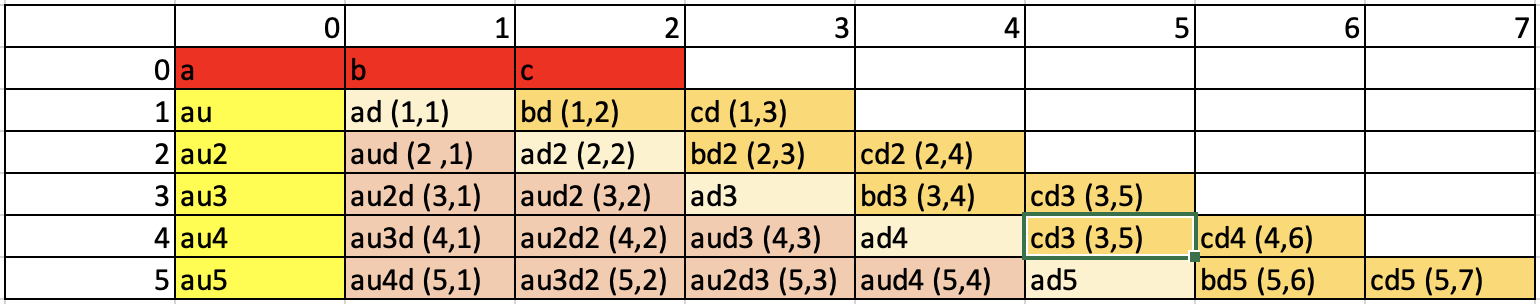

In [ ]:
for i in range(1, baris_matriks):
  for j in range(0, kolom_matriks):
    # mencari kolom pertama
    if j == 0:
      s_zeros[i,j] += s_zeros[0,0]*u**(i)
    elif i >= j:
      s_zeros[i,j] += s_zeros[0,0]*u**(i-j)*d**(j)
    elif j == (i+1):
      s_zeros[i,j] += s_zeros[0,1]*d**(i)
    elif j == (i+2):
      s_zeros[i,j] += s_zeros[0,2]*d**(i)

In [ ]:
f_zeros_amerika_call = np.zeros((baris_matriks, kolom_matriks))

In [ ]:
# mencari harga opsi pada langkah ke-T
# subtitute baris_matriks with N

for j in range(0,baris_matriks+1):
  f_zeros_amerika_call[baris_matriks-1,j] += max(X-s_zeros[baris_matriks-1,j],0)

In [ ]:
for i in range(baris_matriks-2,-1,-1):
  for j in range(0,kolom_matriks):
    if i >= j:
      f_zeros_amerika_call[i,j] += max(X-s_zeros[i,j],np.exp(-1*r*delta_t)*(p*f_zeros_amerika_call[i+1,j]+(1-p)*f_zeros_amerika_call[i+1,j+1]))

In [ ]:
f_zeros_amerika_call

array([[ 0.80509819,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.70235843,  0.91254537,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.61052867,  0.79838726,  1.03194288, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ..., 80.38693806,
        80.56761362,  0.        ]])

In [ ]:
# Harga Opsi Amerika dengan Metode bBTT
hoa_bbtt = np.exp(-1*r*delta_t)*(p_u*f_zeros_amerika_call[1,0] + p_m*f_zeros_amerika_call[1,1] + p_d*f_zeros_amerika_call[1,2])
hoa_bbtt

0.7475605555645022